In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv("/Users/paulecoffet/Documents/isir/These/roborobo3/roborobo3/logs/scorelogtestsupposenotwork/rep00/replay/logscore_0.txt.gz")

In [3]:
gp = df.groupby(['eval', 'iter', 'id'])
meancoop = gp.mean()['othercoop'].copy()
chosen = gp.apply(lambda x: x.loc[x['score'].idxmax()]['othercoop']).copy()

In [4]:
pd.DataFrame({'mean': meancoop, 'chosencoop': chosen}).iloc[200:300]

mean  chosencoop
eval iter id                      
0    3    55  0.238232    0.171731
          56  0.226312    0.587913
          57  0.220587    0.000000
          59  0.226404    0.171731
          60  0.233046    0.171731
...                ...         ...
     4    73  0.231194    0.387892
          74  0.234949    0.228975
          75  0.242356    0.164995
          76  0.235538    0.212139
          77  0.232887    0.117856

[100 rows x 2 columns]

In [5]:
chosen = gp.apply(lambda x: x.loc[x['score'].idxmax()]['othercoop']).copy()

In [6]:
gp['score'].idxmax()

eval  iter  id
0     1     0         378
            1         584
            2        1224
            3         170
            5         166
                   ...   
1     999   94    3197317
            95    3196237
            96    3196537
            97    3196257
            99    3197584
Name: score, Length: 159918, dtype: int64

In [7]:
df.query('eval == 0 and iter == 1 and id == 1').mean()

eval         0.000000
iter         1.000000
id           1.000000
cost         1.000000
nbpart       2.150000
owncoop      0.979841
othercoop    0.188566
score       -0.999887
dtype: float64

In [8]:
meancoop[0],chosen[0]

(iter  id
 1     0     0.176191
       1     0.188566
       2     0.223828
       3     0.205063
       5     0.188902
               ...   
 999   95    0.239141
       96    0.245471
       97    0.245387
       98    0.222995
       99    0.243493
 Name: othercoop, Length: 79919, dtype: float64, iter  id
 1     0     0.212151
       1     0.404070
       2     0.446994
       3     0.737413
       5     0.454582
               ...   
 999   95    0.209601
       96    0.209601
       97    0.209601
       98    0.000000
       99    0.255913
 Length: 79919, dtype: float64)

In [9]:
np.sum(chosen >= meancoop) / len(chosen)

0.5306844757938444

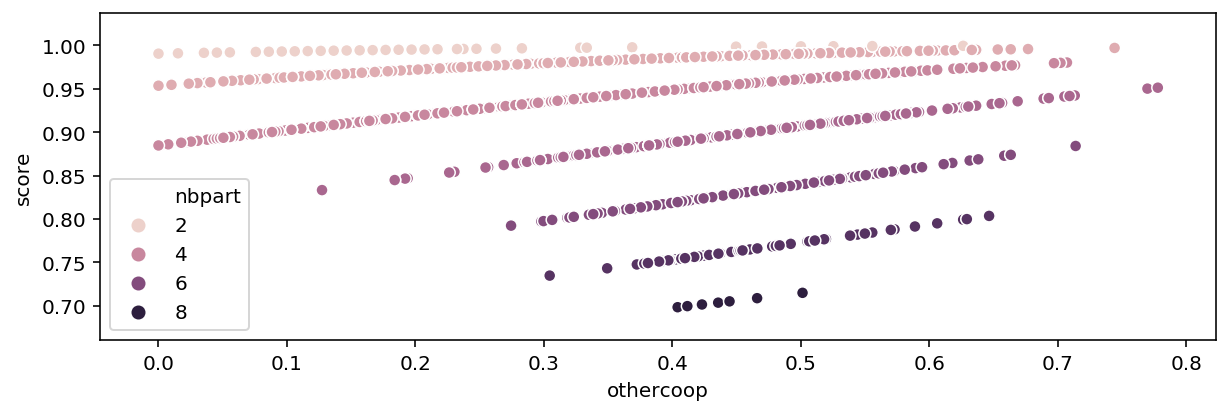

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 3))

sns.scatterplot(data=df.query('eval == 0 and id == 69'), x='othercoop', y='score', hue="nbpart")

In [11]:
print('cor coop', df.corr('spearman').loc['score', 'othercoop'])
print('cor nbpart', df.corr('spearman').loc['score', 'nbpart'])

cor coop 0.006774902030375031
cor nbpart -0.045336938611450925


In [12]:
import scipy.stats

In [13]:
scipy.stats.spearmanr(df['othercoop'], df['score'])

SpearmanrResult(correlation=0.006774902030336158, pvalue=8.771004760917417e-34)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import glob
import scipy.stats
from IPython.display import Video, display, HTML
import re

sns.set()


def gethighest(vals, prefix="logall_"):
        m = np.argmax([int(re.search(f'{prefix}(\d+)', val).group(1)) for val in vals])
        return vals[m]

def read_csvx(path, *args, **kwargs):
    try:
        return pd.read_csv(str(path) +'.gz', *args, **kwargs)
    except Exception as e:
        return pd.read_csv(str(path), *args, **kwargs)

        
def readparams(file):
    params = {} 
    with open(file) as f:
        for line in f:
            line = line[:-1]  # remove \n
            if not line or line.startswith('#') or line.startswith('import'):
                continue
            key, val = line.split('=')
            if val.lower() == 'true' or val.lower() == 'false':
                params[key] = val.lower() == 'true'
            else:
                try:
                    params[key] = float(val)
                except ValueError:
                    params[key] = val
    return params

In [3]:
import tqdm
try:
    params
except NameError:
    params = []
else:
    print('params already exist, you need to force clear it')
    clearparam = input('Clear params? Y/N')
    if clearparam.upper().startswith('Y'):
        params = []
        print('params have been cleared')
    else:
        print('params have not been cleared')
prefix = '/home/pecoffet/remoterobo'
prefix = '/home/ecoffet/robocoop'
prefix = '/Users/paulecoffet/Documents/isir/These/data/'
gen = 0
runname = 'lionscross10-procbtest'


In [ ]:
clearpath=False
try:
    paths
except NameError:
    clearpath=True
else:
    clearpathstr=input('clear paths?')
    clearpath=clearpathstr.upper().startswith('Y')
if clearpath:
    paths = sorted([]
                  + glob.glob(f"{prefix}/logs/{runname}/*/*/*/*/*/*/rep00/replay/", recursive=True)
                  )
#paths = sorted(glob.glob(f"{prefix}/logs/lions-nvar-*-2019-06-*/**/rep00/", recursive=True))
alreadythere = set(param['path'] for param in params)
for path in tqdm.tqdm_notebook(paths):
    if path in alreadythere:
        continue
    try:
        df = read_csvx(path+f"/logscore_{gen}.txt")
    except FileNotFoundError:
        print('not finished yet for', path)
        continue

    # Get Fitness
    #fitness = read_csvx(path + "/../fit.txt", delimiter="\t", names=['gen', 'min', 'q1', 'med', 'q3', 'max'])
    #medfit = fitness.query(f"gen == {gen}")['med'].median()
    medfit=0
    #meanfit = fitness.query(f"gen == {gen}")['fitness'].mean()
    curparam = readparams(glob.glob(path + 'properties*')[0])
    gp = df.groupby(['eval', 'iter', 'id'])
    meancoop = gp.mean()['othercoop']
    chosen = gp.apply(lambda x: x.loc[x['score'].idxmax()]['othercoop'])
    proppc = np.sum(chosen >= meancoop) / len(chosen)
    params.append({'path':path, 'params':curparam, 'proppc': proppc, 'medfit': medfit, 'meanfit': medfit})

diffkeys = set()
missingkeys = set()
i=0
for key in params[i]['params'].keys():
    try:
        if any(params[j]['params'][key] != params[i]['params'][key] for j in range(0, len(params) - 1)) and key not in diffkeys:
            diffkeys.add(key)
            print(key, 'added at step', i)
    except KeyError:
        missingkeys.add(key)
excluded = ['gSeed', 'gLogFilename']
processed = []
for elem in params:
    param = elem['params']
    ess = param['meanA'] / param['nOpti']
    so = param['meanA'] + param['b'] * (param['nOpti'] - 1) / param['nOpti']
    outdict = {'coopopti': (elem['coopopti'] - ess) / (so - ess) , 'truecoopopti': elem['coopopti'],
               'coopmod': (elem['coopmod'] - ess) / (so - ess) , 'truecoopmod': elem['coopmod'], 'nmod': elem['nmod'], 'medfit': elem['medfit'],
               'meanfit': elem['meanfit']}
    for key in diffkeys:
        if key in excluded: continue
        outdict[key] = elem['params'][key]
    processed.append(outdict)
    for key in missingkeys:
        if key in excluded: continue
        outdict[key] = elem['params'].get(key, False)
df = pd.DataFrame(processed)
df.to_pickle(f'all_file_loaded_score_{runname}.pkl.gz')


clear paths? N
